# LSTM

## 라이브러리

In [106]:
import pandas as pd
import numpy as np
import re               # Regular Expression
import pickle           # 토큰화된 단어목록의 인덱스를 저장, 불러오기 위해 사용
from tqdm import tqdm   # 진행상황 Progress Bar를 위한 tqdm library

# 토크나이징/인코딩 관련 라이브러리
from eunjeon import Mecab
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing
from keras.utils import np_utils

# 모델링 관련 라이브러리
from tensorflow.keras.models import load_model

# 그래프 관련 라이브러리
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
if (platform.system() == 'Windows'):
    plt.rc('font', family='Malgun Gothic')
else:
    plt.rc('font', family='AppleGothic')

# 음수(-)가 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False 



데이터 불러오기

In [4]:
X_train = np.array(pd.read_csv('./data/mecab/X_train.csv'))
X_test = np.array(pd.read_csv('./data/mecab/X_test.csv'))

y_train_1 = pd.read_csv('./data/mecab/y_train.csv')['digit_1']
y_test_1 =  pd.read_csv('./data/mecab/y_test.csv')['digit_1']

y_train_2 = pd.read_csv('./data/mecab/y_train.csv')['digit_2']
y_test_2 =  pd.read_csv('./data/mecab/y_test.csv')['digit_2']

y_train_3 = pd.read_csv('./data/mecab/y_train.csv')['digit_3']
y_test_3 =  pd.read_csv('./data/mecab/y_test.csv')['digit_3']

In [5]:
# 한국표준산업분류 딕셔너리 불러오기

with open('./data/dictionary/digit_1_dict.pickle', 'rb') as handle:
    digit_1_dict = pickle.load(handle)

with open('./data/dictionary/digit_2_dict.pickle', 'rb') as handle:
    digit_2_dict = pickle.load(handle)

with open('./data/dictionary/digit_3_dict.pickle', 'rb') as handle:
    digit_3_dict = pickle.load(handle)

In [6]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## 대분류

In [7]:
# 레이블 인코딩

digit_1_list = list(digit_1_dict.keys())

le1 = preprocessing.LabelEncoder()

le1.fit(digit_1_list)
y_train_1 = le1.transform(y_train_1)
y_test_1 = le1.transform(y_test_1)

y_train_1 = np_utils.to_categorical(y_train_1)
y_test_1 = np_utils.to_categorical(y_test_1)

In [130]:
# le1 객체에 담긴 어휘 분석 정보가 폴더의 le1.pickle에 저장

with open('./data/mecab/le1.pickle', 'wb') as handle:
     pickle.dump(le1, handle)

In [12]:
# 저장된 le1 객체를 불러오는 부분

with open('./data/mecab/le1.pickle', 'rb') as handle:
    le1 = pickle.load(handle)

Epoch 1/10
5000/5000 [==============================] - 544s 109ms/step - loss: 0.1471 - acc: 0.9593 - val_loss: 0.0949 - val_acc: 0.9722

Epoch 00001: val_acc improved from -inf to 0.97217, saving model to best_model.h5
Epoch 2/10
5000/5000 [==============================] - 542s 108ms/step - loss: 0.0762 - acc: 0.9775 - val_loss: 0.0911 - val_acc: 0.9734

Epoch 00002: val_acc improved from 0.97217 to 0.97343, saving model to best_model.h5
Epoch 3/10
5000/5000 [==============================] - 545s 109ms/step - loss: 0.0622 - acc: 0.9814 - val_loss: 0.0898 - val_acc: 0.9742

Epoch 00003: val_acc improved from 0.97343 to 0.97417, saving model to best_model.h5
Epoch 4/10
5000/5000 [==============================] - 537s 107ms/step - loss: 0.0529 - acc: 0.9840 - val_loss: 0.0934 - val_acc: 0.9740

Epoch 00004: val_acc did not improve from 0.97417
Epoch 5/10
5000/5000 [==============================] - 537s 107ms/step - loss: 0.0454 - acc: 0.9862 - val_loss: 0.0978 - val_acc: 0.9738

Epo

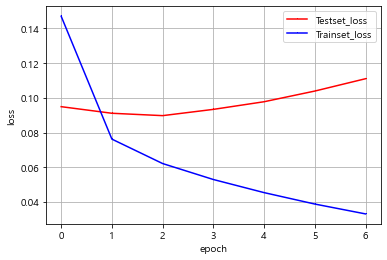

In [115]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 34265
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(19, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('ed200_hu128_ep10_bs128_sftmx_cc.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_1, epochs=10, callbacks=[es, mc], batch_size=128, validation_split=0.2)

y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [116]:
loaded_model = load_model('./data/model/ed200_hu128_ep10_bs128_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_1)[1]))

6250/6250 [==============================] - 50s 8ms/step - loss: 0.0903 - acc: 0.9744

 테스트 정확도: 0.9744


### 대분류 예측기

In [8]:
# 저장된 Tokenizer 객체를 불러오는 부분

with open('./data/mecab/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [9]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit1_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')
stopwords = list(stopwords['stopwords'])


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le1.inverse_transform([label.argmax()])[0])
  print(digit_1_dict[le1.inverse_transform([label.argmax()])[0]])

In [15]:
sentiment_predict("중학교|학생들|교육서비스")

중학교학생들교육서비스
['중학교', '학생', '들', '교육', '서비스']
['중학교', '학생', '교육', '서비스']
[[745, 38, 28, 2]]
[[  0   0   0   0   0   0   0   0   0   0   0 745  38  28   2]]
[[2.7874928e-06 4.1051479e-08 5.9895888e-06 2.6112444e-05 1.0480729e-06
  4.4714175e-06 3.8426719e-05 6.4210208e-06 4.4795415e-05 2.9869991e-05
  2.3546571e-07 1.0225277e-06 1.5727010e-05 6.3783991e-05 1.1394721e-05
  9.9863821e-01 7.5766671e-05 8.0841332e-04 2.2544955e-04]]
P
교육 서비스업(85)


In [ ]:
# y_test_1_predicted = pd.DataFrame(loaded_model.predict(X_test))

## 중분류

In [16]:
len(pd.DataFrame(y_train_2)['digit_2'].unique())

74

In [17]:
len(digit_2_dict)

77

In [19]:
# 레이블 인코딩

digit_2_list = list(digit_2_dict.keys())

le2 = preprocessing.LabelEncoder()

le2.fit(digit_2_list)
y_train_2 = le2.transform(y_train_2)
y_test_2 = le2.transform(y_test_2)

y_train_2 = np_utils.to_categorical(y_train_2, num_classes=len(digit_2_list))
y_test_2 = np_utils.to_categorical(y_test_2, num_classes=len(digit_2_list))

In [20]:
len(y_train_2[0])

77

In [21]:
len(y_test_2[0])

77

In [24]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 34265
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(77, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_2, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/10
6400/6400 [==============================] - 646s 101ms/step - loss: 0.3489 - acc: 0.9098 - val_loss: 0.2221 - val_acc: 0.9370

Epoch 00001: val_acc improved from -inf to 0.93696, saving model to best_model.h5
Epoch 2/10
6400/6400 [==============================] - 648s 101ms/step - loss: 0.1834 - acc: 0.9470 - val_loss: 0.2120 - val_acc: 0.9393

Epoch 00002: val_acc improved from 0.93696 to 0.93928, saving model to best_model.h5
Epoch 3/10
6400/6400 [==============================] - 570s 89ms/step - loss: 0.1523 - acc: 0.9548 - val_loss: 0.2094 - val_acc: 0.9409

Epoch 00003: val_acc improved from 0.93928 to 0.94093, saving model to best_model.h5
Epoch 4/10
6400/6400 [==============================] - 493s 77ms/step - loss: 0.1317 - acc: 0.9602 - val_loss: 0.2167 - val_acc: 0.9405

Epoch 00004: val_acc did not improve from 0.94093
Epoch 5/10
6400/6400 [==============================] - 359s 56ms/step - loss: 0.1159 - acc: 0.9646 - val_loss: 0.2252 - val_acc: 0.9396

Epoch 

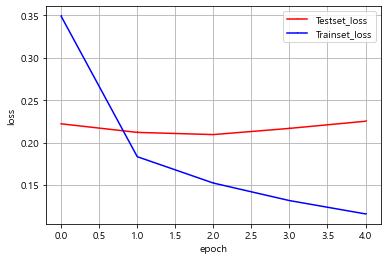

In [25]:
y_test_loss = history.history['val_loss']
y_train_loss = history.history['loss']

x_len = np.arange(len(y_test_loss))

plt.plot (x_len, y_test_loss, marker=',', c='red', label='Testset_loss')
plt.plot(x_len, y_train_loss, marker=',', c='blue', label='Trainset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [26]:
loaded_model = load_model('./best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_2)[1]))

6250/6250 [==============================] - 20s 3ms/step - loss: 0.2083 - acc: 0.9417

 테스트 정확도: 0.9417


### 중분류 예측기

In [37]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le2.inverse_transform([label.argmax()])[0])
  print(digit_2_dict[le2.inverse_transform([label.argmax()])[0]])

In [36]:
sentiment_predict('금속재료|제조 및 가공|볼 베어링 제조')

금속재료제조 및 가공볼 베어링 제조
['금속', '재료', '제조', '및', '가공', '볼', '베어링', '제조']
['금속', '재료', '제조', '및', '가공', '볼', '베어링', '제조']
[[99, 193, 29, 40, 2043, 1413, 29]]
[[   0    0    0    0    0    0    0    0   99  193   29   40 2043 1413
    29]]
[[9.7917784e-08 3.9562511e-08 1.0210095e-07 5.9847608e-08 5.7538308e-08
  1.4887435e-06 1.2957822e-08 1.6159271e-05 6.2500294e-07 1.2437606e-07
  2.6995622e-05 1.2215528e-05 1.7048354e-06 6.2834765e-06 2.0736394e-05
  5.7679013e-06 7.0589986e-06 2.8973041e-05 1.2308511e-06 3.6207723e-04
  1.7849918e-04 2.1902248e-03 6.0853947e-02 7.5720233e-04 2.2640103e-03
  3.4573795e-03 9.1568601e-01 1.2264292e-02 1.5610836e-03 1.0656458e-04
  3.3411910e-05 5.0124319e-05 1.2374792e-07 6.9652537e-09 2.4173809e-07
  3.7574730e-05 3.2814384e-07 2.7774479e-06 1.6088799e-05 4.7772204e-07
  3.7525846e-05 2.5843149e-06 8.9434519e-07 2.0880084e-07 1.0605176e-08
  4.5869450e-07 2.2420304e-08 2.2371739e-06 3.4553668e-08 1.5844160e-08
  3.6935727e-08 1.3783360e-07 1.7612372e-08 2.2

In [54]:
loaded_model = load_model('./best_model2.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_3)[1]))

6250/6250 [==============================] - 51s 8ms/step - loss: 13.4765 - acc: 0.0036

 테스트 정확도: 0.0036


## 소분류

In [39]:
# 레이블 인코딩

digit_3_list = list(digit_3_dict.keys())

le3 = preprocessing.LabelEncoder()

le3.fit(digit_3_list)
y_train_3 = le3.transform(y_train_3)
y_test_3 = le3.transform(y_test_3)

y_train_3 = np_utils.to_categorical(y_train_3, num_classes=len(digit_3_list))
y_test_3 = np_utils.to_categorical(y_test_3, num_classes=len(digit_3_list))

In [42]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

vocab_size = 34265
embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(232, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train_3, epochs=10, callbacks=[es, mc], batch_size=100, validation_split=0.2)

Epoch 1/10
6400/6400 [==============================] - 351s 55ms/step - loss: 0.6143 - acc: 0.8567 - val_loss: 0.3590 - val_acc: 0.9060

Epoch 00001: val_acc improved from -inf to 0.90602, saving model to best_model.h5
Epoch 2/10
6400/6400 [==============================] - 387s 60ms/step - loss: 0.2998 - acc: 0.9197 - val_loss: 0.3362 - val_acc: 0.9111

Epoch 00002: val_acc improved from 0.90602 to 0.91115, saving model to best_model.h5
Epoch 3/10
6400/6400 [==============================] - 380s 59ms/step - loss: 0.2502 - acc: 0.9308 - val_loss: 0.3336 - val_acc: 0.9119

Epoch 00003: val_acc improved from 0.91115 to 0.91189, saving model to best_model.h5
Epoch 4/10
6400/6400 [==============================] - 342s 53ms/step - loss: 0.2192 - acc: 0.9385 - val_loss: 0.3351 - val_acc: 0.9132

Epoch 00004: val_acc improved from 0.91189 to 0.91319, saving model to best_model.h5
Epoch 5/10
6400/6400 [==============================] - 350s 55ms/step - loss: 0.1957 - acc: 0.9444 - val_loss:

In [43]:
loaded_model = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test_3)[1]))

6250/6250 [==============================] - 23s 4ms/step - loss: 0.3311 - acc: 0.9143: 0s - loss: 0.33

 테스트 정확도: 0.9143


### 소분류 예측기

In [46]:
mecab = Mecab()
loaded_model = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
max_len = 15
stopwords = pd.read_csv('./data/stopwords/stopwords_concat.csv')


def sentiment_predict2(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  print(new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  print(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  print(new_sentence)
  encoded = tokenizer.texts_to_sequences(["{}".format(new_sentence)]) # 정수 인코딩
  print(encoded)
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  print(pad_new)
  label = loaded_model.predict(pad_new) # 예측
  print(label)
  print(le3.inverse_transform([label.argmax()])[0])
  print(digit_3_dict[le3.inverse_transform([label.argmax()])[0]])

In [48]:
sentiment_predict2('정비회사에서|자동차의전반적인|정비 종합수리서비스')

정비회사에서자동차의전반적인정비 종합수리서비스
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
['정비', '회사', '에서', '자동차', '의', '전반', '적', '인', '정비', '종합', '수리', '서비스']
[[271, 291, 43, 2169, 175, 271, 228, 46, 2]]
[[   0    0    0    0    0    0  271  291   43 2169  175  271  228   46
     2]]
[[2.25543495e-08 6.05824141e-07 1.46671744e-10 1.06609705e-05
  7.70816674e-11 1.70350845e-08 1.28942315e-10 1.73955748e-08
  2.46597381e-10 1.65171571e-10 2.27767916e-10 3.23220062e-10
  1.34238731e-10 1.91093894e-11 5.29234256e-09 2.25108465e-09
  1.76460874e-10 2.92087021e-09 1.63499308e-07 2.07227679e-10
  4.81583350e-11 1.70529315e-08 4.16814459e-08 2.74717887e-11
  7.91270249e-09 1.07565179e-09 1.90920557e-10 1.01880504e-09
  1.30524966e-10 1.16911991e-09 2.71794809e-09 1.13763790e-11
  4.21847973e-10 1.15860023e-12 2.39433307e-10 3.19270010e-09
  1.26816024e-09 6.26243875e-08 7.20114857e-09 2.93753466e-10
  6.30222132e-08 5.38868399e-08 8.70925376e-09 3.78718461e-08
  1.62408498e-09 8.9349

In [51]:
test_data = np.array(pd.read_csv('./data/mecab/test_data.csv'))

In [78]:
loaded_model_1 = load_model('./data/model/digit1_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_1_predicted = loaded_model_1.predict(test_data)

In [79]:
loaded_model_2 = load_model('./data/model/digit2_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_2_predicted = loaded_model_2.predict(test_data)

In [80]:
loaded_model_3 = load_model('./data/model/digit3_ed200_hu128_ep10_bs128_sftmx_cc.h5')
y_test_3_predicted = loaded_model_3.predict(test_data)

In [100]:
le1.inverse_transform([y_test_1_predicted[0].argmax()])

array(['I'], dtype='<U1')

In [108]:
temp_list_1 = []
temp_list_2 = []
temp_list_3 = []

for i in tqdm(range(0, len(y_test_1_predicted))):
    temp_list_1.append(le1.inverse_transform([y_test_1_predicted[i].argmax()])[0])
    temp_list_2.append(le2.inverse_transform([y_test_2_predicted[i].argmax()])[0])
    temp_list_3.append(le3.inverse_transform([y_test_3_predicted[i].argmax()])[0])

100%|██████████| 100000/100000 [00:11<00:00, 8534.98it/s]


In [115]:
test_data = pd.read_csv('./data/test.csv')

In [117]:
test_data['digit_1'] = temp_list_1
test_data['digit_2'] = temp_list_2
test_data['digit_3'] = temp_list_3

In [121]:
test_data.to_csv('./data/output/final.csv', encoding='CP949', index=False)

In [124]:
translated_data = test_data.copy()
translated_data['digit_1'] = translated_data['digit_1'].replace(digit_1_dict)
translated_data['digit_2'] = translated_data['digit_2'].replace(digit_2_dict)
translated_data['digit_3'] = translated_data['digit_3'].replace(digit_3_dict)

In [126]:
translated_data.to_csv('./data/output/final_translated.csv', encoding='CP949', index=False)